In [1]:
!nvidia-smi

Wed Aug  9 08:08:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:13:00.0  On |                  N/A |
|  0%   56C    P8    19W / 220W |    755MiB /  8192MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# [Nvidia Rapids](https://rapids.ai/)


In [1]:
from cuml.cluster import HDBSCAN
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score
import os

import umap
import requests
import pandas as pd
import numpy as np
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import cudf
import cuml

%matplotlib inline

## K-Means

- No significant speedup between CPU and GPU. Tested with (100_000, 25)
- init
  - 'scalable-k-means++': Uses fast and stable scalable kmeans++ initialization.
  - 'random': Choose n_cluster observations (rows) at random from data for the initial centroids.


In [5]:
n_samples = 100000
n_features = 25

n_clusters = 8
random_state = 0

In [6]:
device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std=0.1,
)

# Copy CuPy arrays from GPU memory to host memory (NumPy arrays).
# This is done to later compare CPU and GPU results.
host_data = device_data.get()
host_labels = device_labels.get()

In [8]:
kmeans_sk = skKMeans(
    init="k-means++", n_clusters=n_clusters, random_state=random_state, n_init="auto"
)
%timeit kmeans_sk.fit(host_data)

89.5 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
kmeans_cuml = cuKMeans(
    init="scalable-k-means++", n_clusters=n_clusters, random_state=random_state
)

%timeit kmeans_cuml.fit(device_data)

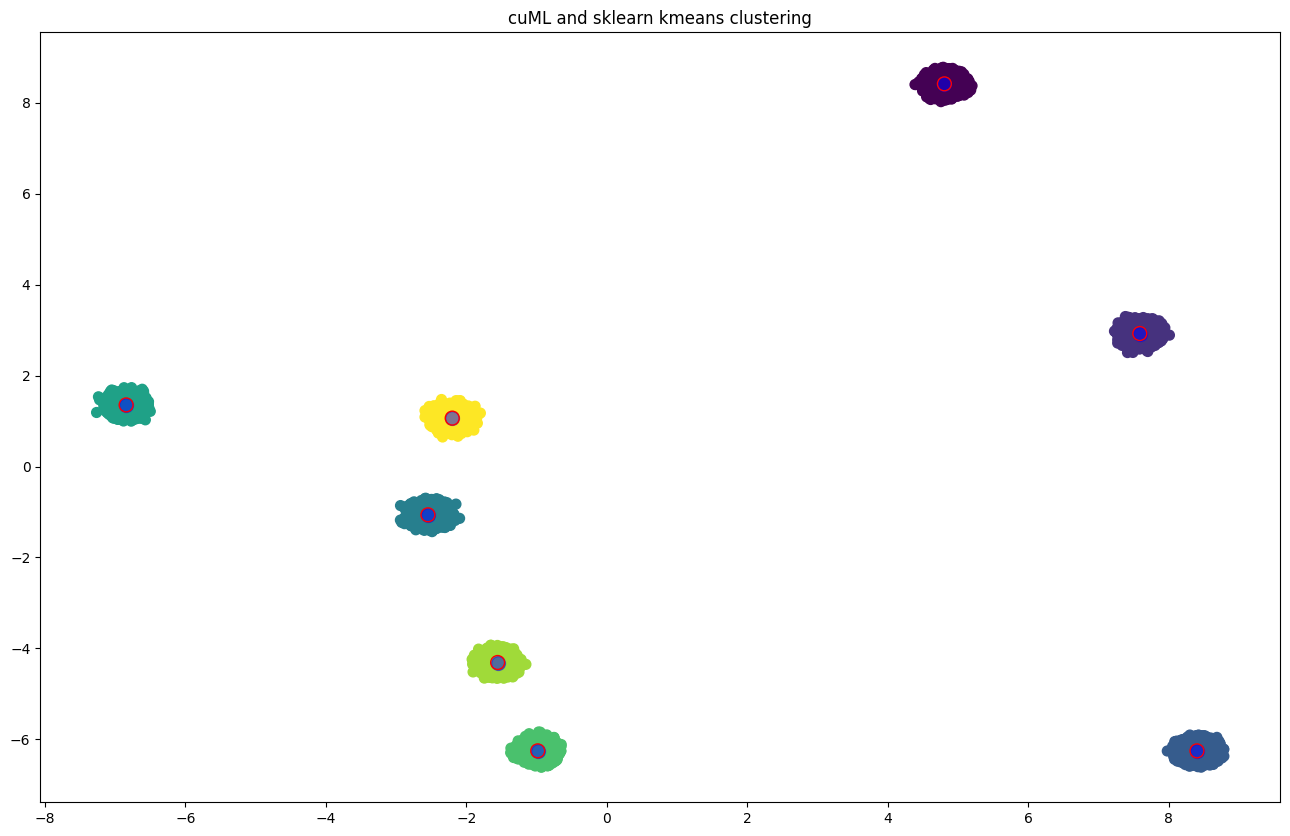

In [8]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:, 0], host_data[:, 1], c=host_labels, s=50, cmap="viridis")

# plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:, 0], centers_sk[:, 1], c="blue", s=100, alpha=0.5)

# plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(
    cupy.asnumpy(centers_cuml[:, 0]),
    cupy.asnumpy(centers_cuml[:, 1]),
    facecolors="none",
    edgecolors="red",
    s=100,
)

plt.title("cuML and sklearn kmeans clustering")

plt.show()

In [9]:
# Compare CPU and GPU performance
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.get())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print(
    "compare kmeans: cuml vs sklearn labels_ are "
    + ("equal" if passed else "NOT equal")
)

compare kmeans: cuml vs sklearn labels_ are equal
CPU times: user 18 ms, sys: 754 µs, total: 18.8 ms
Wall time: 18.3 ms


## UMAP

- CPU: 1min 4s
- GPU: 3.6 s


In [2]:
# import requests

# csv_data = requests.get('https://www.openml.org/data/get_csv/18238735/phpnBqZGZ')

# with open('fashion-mnist.csv', 'w') as f:
#     f.write(csv_data.text)

In [2]:
pal = [
    "#9e0142",
    "#d8434e",
    "#f67a49",
    "#fdbf6f",
    "#feeda1",
    "#f1f9a9",
    "#bfe5a0",
    "#74c7a5",
    "#378ebb",
    "#5e4fa2",
]
color_key = {str(d): c for d, c in enumerate(pal)}

### CPU


In [2]:
source_df = pd.read_csv("fashion-mnist.csv")
data = source_df.iloc[:, :784].values.astype(np.float32)
target = source_df["class"].values

In [4]:
%%time
reducer = umap.UMAP(
    n_neighbors=15, n_components=2, n_epochs=500, min_dist=0.1, random_state=42
)

embedding = reducer.fit_transform(data)

CPU times: user 2min 13s, sys: 20.6 s, total: 2min 33s
Wall time: 1min 4s


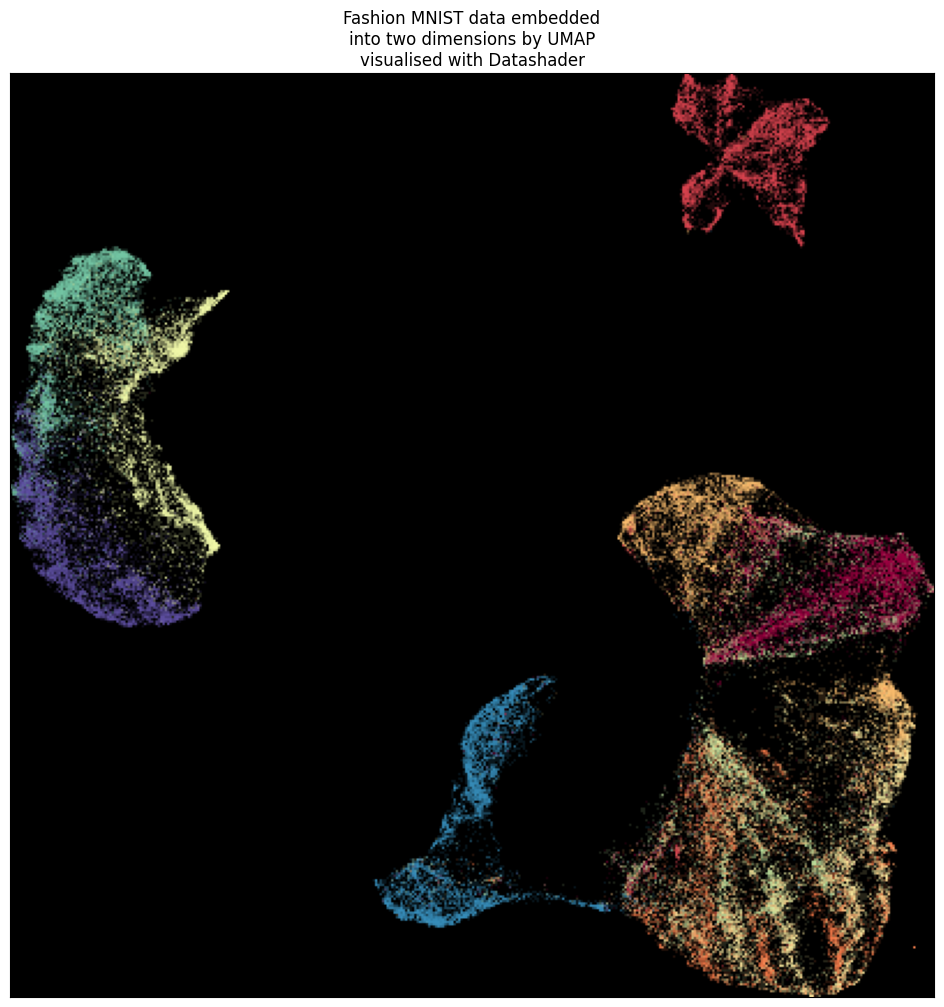

In [6]:
df = pd.DataFrame(embedding, columns=("x", "y"))
df["class"] = pd.Series([str(x) for x in target], dtype="category")

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, "x", "y", ds.count_cat("class"))
img = tf.shade(agg, color_key=color_key, how="eq_hist")

utils.export_image(img, filename="fashion-mnist", background="white")

image = plt.imread("fashion-mnist.png")
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title(
    "Fashion MNIST data embedded\n"
    "into two dimensions by UMAP\n"
    "visualised with Datashader",
    fontsize=12,
)

plt.show()

### GPU


In [3]:
# Using cudf Dataframe here is not likely to help with performance
# However, it's a good opportunity to get familiar with the API
source_df = cudf.read_csv("fashion-mnist.csv")

data = source_df.loc[:, source_df.columns[:-1]]
target = source_df["class"]

In [8]:
from cuml import PCA

reducer = PCA(n_components=2, random_state=42)
embedding = reducer.fit_transform(data.astype(np.float32))

In [4]:
%%time
reducer = cuml.UMAP(n_neighbors=15, n_components=2, n_epochs=500, min_dist=0.1)
embedding = reducer.fit_transform(data)

CPU times: user 3.27 s, sys: 40.6 ms, total: 3.31 s
Wall time: 3.33 s


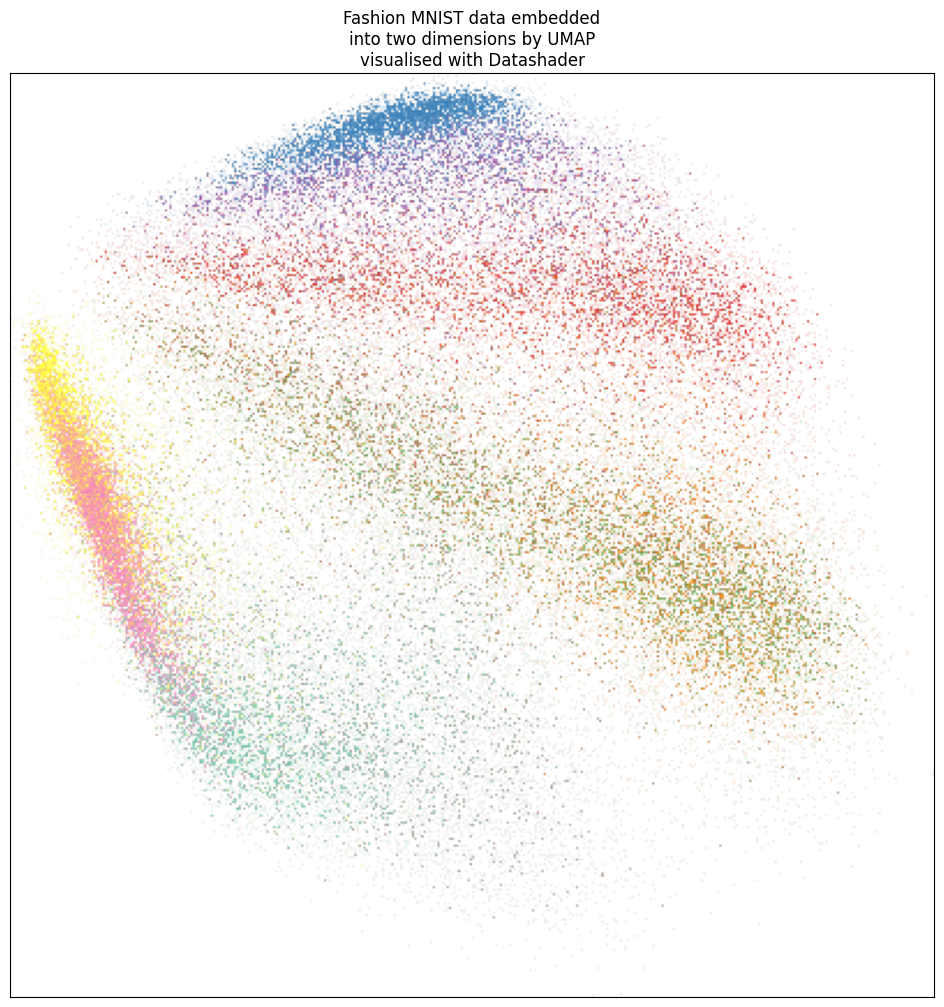

In [9]:
df = embedding.to_pandas()
df.columns = ["x", "y"]
df["class"] = pd.Series(
    [str(x) for x in target.to_arrow().to_pylist()], dtype="category"
)

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, "x", "y", ds.count_cat("class"))
img = tf.shade(agg, how="eq_hist")  # color_key=color_key,

utils.export_image(img, filename="fashion-mnist", background="")

image = plt.imread("fashion-mnist.png")
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title(
    "Fashion MNIST data embedded\n"
    "into two dimensions by UMAP\n"
    "visualised with Datashader",
    fontsize=12,
)

plt.show()